# Подготовка нашего датасета
Данные были скачаны с использованием API hh.ru

В условиях пользования серисом и данными hh.ru говорится:

_1.5. Конечными пользователями Приложения могут быть юридические и физические лица, являющиеся как работодателями или  организациями, оказывающими услуги по поиску и подбору персонала и/или по поиску работы и трудоустройству (кадровые агентства), так и соискателями. В случае, если конечными пользователями Приложения являются организации и физические лица, являющиеся работодателями или кадровыми агентствами, то указанные лица вправе использовать Сервис только для целей привлечения потенциальных работников и их последующего трудоустройства непосредственно в такие юридические лица (у таких физических лиц) или у клиентов таких кадровых агентств._

То есть мы вполне можем использовать эти данные в работе.

Данные скачаны для того, чтобы мы имели возможность обучить модель на большом объёме данных, добившись более точного результата.

К сожалению, времени в рамках хакатона не достаточно, чтобы детально исследовать данные и сделать выборку более сбалансированной. После прохождения во второй этап планируется посвятить время глубокому изучению данных и создать оптимальную для обучения качественной модели выборку.

# Установка и загрузка библиотек

In [ ]:
!pip install pytorch-tabnet transformers

In [ ]:
import pandas as pd
import shutil
import os
import numpy as np
from transformers import BertTokenizer
from transformers import BertModel
import torch
import random
import pickle

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
plt.figure(figsize=(12, 6), dpi=100)
sns.set(rc={'figure.figsize':(12, 6), 'figure.dpi':100})
plt.style.use('bmh')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

<Figure size 1200x600 with 0 Axes>

In [ ]:
tokenizer = BertTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
bert = BertModel.from_pretrained('DeepPavlov/rubert-base-cased')

# Датафрейм

Перекинем скачанные данные для работы с ними

In [ ]:
!unzip '/content/drive/My Drive/colab_data/hh_salary.zip' -d '/content/raw_data'

Создадим из скачанных данных датафрейм для удобства работы:

In [ ]:
path = 'raw_data'
raw_files = [os.path.join(path, csv_file) for csv_file in os.listdir(path) if 'csv' in csv_file]
len(raw_files)

2878

In [ ]:
df = pd.concat([pd.read_csv(csv_file) for csv_file in raw_files], axis=0)
df.head(5)

,name,area_id,area_name,salary_from,salary_to,experience,schedule,employment,description,employer
0,Инженер-геодезист,95,Тюмень,25000.0,NaN,noExperience,fullDay,full,Обязанности: выполнение инженерно-геодезически...,2671264
1,Ведущий инженер-программист,2,Санкт-Петербург,65000.0,NaN,between1And3,fullDay,full,Обязанности: Разработка управляющих программ в...,46539
2,"Менеджер по работе с клиентами (Дмитров, ул. М...",2023,Дмитров,25000.0,NaN,noExperience,shift,full,Компания «ВАЙЛДБЕРРИЗ» – это один из крупнейши...,87021
3,Автоэлектрик-диагност,53,Краснодар,30000.0,NaN,between1And3,shift,full,Обязанности: - проведение компьютерной диагнос...,2681079
4,Продавец-консультант в салон связи Связной,1849,Калач,31000.0,NaN,noExperience,fullDay,full,Ты заряжен энергией и хочешь превратить ее в д...,533


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1976131 entries, 0 to 985
Data columns (total 10 columns):
 #   Column       Dtype  
---  ------       -----  
 0   name         object 
 1   area_id      int64  
 2   area_name    object 
 3   salary_from  float64
 4   salary_to    float64
 5   experience   object 
 6   schedule     object 
 7   employment   object 
 8   description  object 
 9   employer     int64  
dtypes: float64(2), int64(2), object(6)
memory usage: 165.8+ MB


В наших данных очень скошенная выборка по городам. Получается очень длинный хвост. Поэтому будет достаточно трудно сделать точный предикт зарплат для всех городов России. Вот пример топ-20 городов нашей выборки:

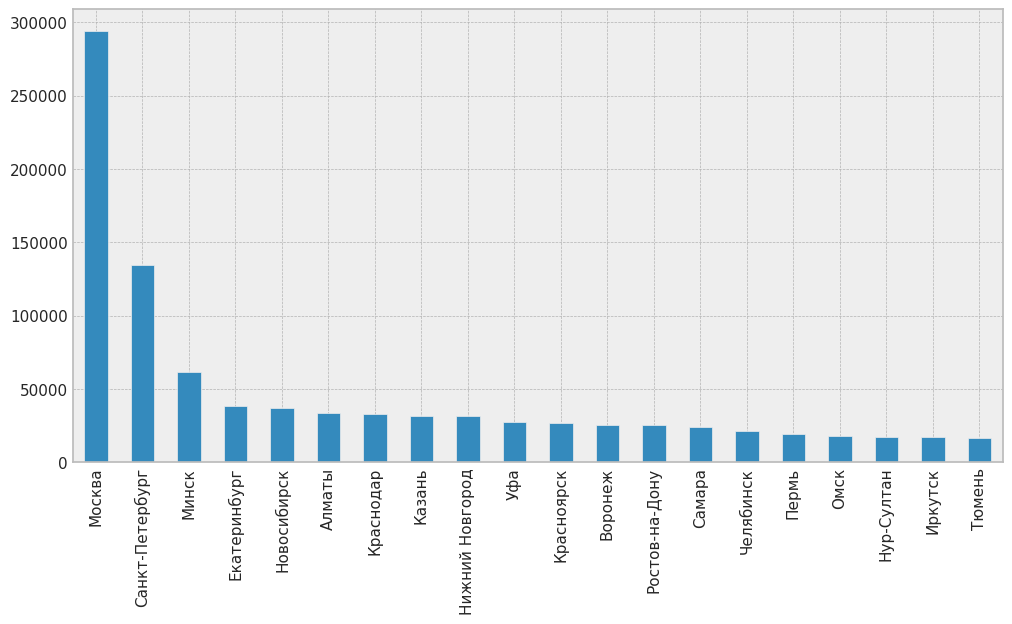

In [ ]:
df.area_name.value_counts()[0:20].plot.bar()

В датасете содержатся различные населённые пункты, при этом имеются и города не из России. Поэтому ограничим нашу выборку лишь несколькими городами России.

In [ ]:
cities = ['Санкт-Петербург', 'Москва', 'Екатеринбург', 'Новосибирск', 'Краснодар', 'Казань', 'Нижний Новгород', 'Уфа', 'Красноярск', 'Воронеж', 'Ростов-на-Дону', 'Самара', 'Челябинск', 'Пермь', 'Омск', 'Иркутск', 'Тюмень', 'Волгоград', 'Барнаул', 'Саратов', 'Ярославль', 'Ижевск', 'Тула', 'Томск', 'Сочи', 'Хабаровск', 'Тверь', 'Владивосток', 'Рязань', 'Кемерово', 'Набережные Челны', 'Оренбург', 'Тольятти', 'Белгород', 'Киров (Кировская область)', 'Владимир', 'Ульяновск', 'Липецк', 'Чебоксары', 'Калининград', 'Пенза', 'Новокузнецк', 'Иваново (Ивановская область)', 'Калуга', 'Ставрополь', 'Брянск', 'Сургут', 'Химки', 'Курск', 'Смоленск', 'Вологда', 'Симферополь', 'Подольск (Московская область)', 'Орел', 'Астрахань', 'Караганда', 'Кострома', 'Тамбов', 'Мытищи', 'Улан-Удэ', 'Брест', 'Архангельск', 'Одинцово', 'Мурманск', 'Магнитогорск', 'Зеленоград', 'Новороссийск', 'Люберцы', 'Балашиха', 'Череповец', 'Йошкар-Ола', 'Курган', 'Могилев', 'Гродно', 'Саранск', 'Красногорск', 'Чита', 'Севастополь', 'Домодедово', 'Благовещенск (Амурская область)', 'Псков', 'Нижневартовск', 'Великий Новгород', 'Петрозаводск', 'Волжский(Волгоградская область)', 'Стерлитамак', 'Нижний Тагил', 'Дзержинск (Нижегородская область)', 'Абакан', 'Пятигорск', 'Обнинск', 'Новый Уренгой', 'Салават', 'Королев', 'Таганрог', 'Старый Оскол', 'Энгельс', 'Ангарск', 'Бийск', 'Лобня', 'Южно-Сахалинск', 'Сыктывкар', 'Адлер', 'Пушкино (Московская область)', 'Видное', 'Щелково', 'Дмитров', 'Долгопрудный', 'Нижнекамск', 'Анапа', 'Раменское', 'Братск', 'Ногинск', 'Шахты', 'Петропавловск-Камчатский', 'Альметьевск', 'Солнечногорск', 'Новочеркасск', 'Серпухов', 'Нефтекамск', 'Новомосковск (Тульская область)', 'Миасс', 'Коломна', 'Чехов', 'Ханты-Мансийск', 'Якутск', 'Комсомольск-на-Амуре', 'Армавир', 'Волгодонск', 'Батайск', 'Жуковский', 'Истра', 'Сергиев Посад', 'Орск', 'Рыбинск', 'Реутов', 'Ковров', 'Тобольск', 'Наро-Фоминск', 'Геленджик', 'Клин', 'Электросталь', 'Махачкала', 'Ялта', 'Сызрань', 'Октябрьский (Республика Башкортостан)', 'Каменск-Уральский', 'Березники', 'Балаково', 'Колпино', 'Кстово', 'Всеволожск', 'Аксай (Ростовская область)', 'Магадан', 'Гатчина', 'Орехово-Зуево', 'Троицк (Московская область)', 'Златоуст', 'Елабуга', 'Первоуральск', 'Ачинск', 'Нефтеюганск', 'Муром', 'Пушкин', 'Северодвинск', 'Ноябрьск', 'Уссурийск', 'Ессентуки', 'Елец', 'Азов', 'Верхняя Пышма', 'Прокопьевск', 'Бердск', 'Березовский (Свердловская область)', 'Белово', 'Димитровград', 'Майкоп', 'Выборг', 'Норильск', 'Воскресенск', 'Петропавловск', 'Ухта', 'Находка', 'Ступино', 'Арзамас', 'Великие Луки', 'Котельники', 'Дубна', 'Новочебоксарск', 'Минеральные Воды', 'Туапсе', 'Кингисепп', 'Щербинка', 'Климовск (Московская область)', 'Зеленодольск (Республика Татарстан)', 'Глазов', 'Ленинск-Кузнецкий', 'Сарапул', 'Железногорск (Курская область)', 'Владикавказ', 'Горно-Алтайск', 'Фрязино', 'Воткинск', 'Новокуйбышевск', 'Каменск-Шахтинский', 'Бузулук', 'Невинномысск', 'Копейск', 'Новоалтайск', 'Нахабино', 'Павловский Посад', 'Усинск', 'Керчь', 'Борисоглебск', 'Соликамск', 'Звенигород', 'Егорьевск', 'Александров', 'Славянск-на-Кубани', 'Кисловодск', 'Ржев', 'Большой Камень', 'Камышин', 'Тихорецк', 'Можайск', 'Элиста', 'Темрюк', 'Вязьма', 'Когалым', 'Бугульма', 'Ейск', 'Жигулевск', 'Асбест', 'Нальчик', 'Черкесск', 'Биробиджан', 'Тихвин', 'Сестрорецк', 'Юрга', 'Волоколамск', 'Ростов (Ярославская область)', 'Балабаново', 'Сальск', 'Петергоф', 'Гусь-Хрустальный', 'Ломоносов', 'Евпатория', 'Волжск', 'Грязи', 'Краснознаменск (Московская область)', 'Салехард', 'Алушта', 'Нерюнгри', 'Тутаев', 'Усть-Илимск', 'Шадринск', 'Курчатов', 'Воркута', 'Новотроицк (Оренбургская область)', 'Гагарин', 'Минусинск', 'Кинешма', 'Благовещенск (Республика Башкортостан)', 'Ахтубинск', 'Краснокамск', 'Лесосибирск', 'Чапаевск', 'Озерск (Челябинская область)', 'Мирный (Республика Саха (Якутия))', 'Кронштадт', 'Киров (Калужская область)', 'Донецк (Ростовская область)', 'Березовский (Кемеровская область)', 'Тамань', 'Грозный', 'Строитель (Белгородская область)', 'Суздаль', 'Зеленогорск (Ленинградская обл)', 'Шлиссельбург', 'Быково (Московская область)', 'Амурск', 'Лазаревское', 'Котлас', 'Калач-на-Дону', 'Североморск', 'Зерноград', 'Отрадный (Самарская область)', 'Котовск (Тамбовская область)', 'Урюпинск', 'Заречный (Свердловская область)', 'Радужный (Ханты-Мансийский АО - Югра)', 'Заречный (Пензенская область)', 'Красноармейск (Московская область)', 'Черноголовка', 'Павловск (Ленинградская область)', 'Черногорск', 'Тында', 'Бодайбо', 'Ленинградская станица', 'Фролово', 'Рощино (Ленинградская область)', 'Лермонтов', 'Славгород (Алтайский край)', 'Николаевск-на-Амуре', 'Валдай', 'Саянск', 'Приморско-Ахтарск', 'Гурьевск (Кемеровская область)', 'Горки-10 (Московская область, Одинцовский район)', 'Дубна (Тульская область)', 'Гурьевск (Калининградская область)', 'Забайкальск', 'Запрудня (Московская область)', 'Каспийск', 'Александровск (Пермский край)', 'Славянка (Приморский край)', 'Павловск (Алтайский край)', 'Иннополис', 'Нарьян-Мар', 'Шексна', 'Печоры', 'Нижнеудинск', 'Дно', 'Краснослободск (Волгоградская область)', 'Советский (Ханты-Мансийский АО)', 'Советск (Калининградская область)', 'Красный Бор (Ленинградская область)', 'Любань (Ленинградская область)', 'Аннино (Ленинградская область)', 'Быков (Сахалинская область)', 'Птичник (Еврейская АО)']

Выберем только те значения нашего датафрейма, которые относятся к выбранным нами городам.

Также удалим пропуски и перемешаем данные для более гладкого процесса обучения модели.


In [ ]:
pattern = '|'.join(cities)

In [ ]:
df = df[df.area_name.str.contains(pattern) == True]
df = df[['name', 'area_name', 'salary_from', 'experience', 'schedule', 'employment']]
df = df.dropna()
df = df.sample(frac=1).reset_index(drop=True)
df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/strings.py:1954: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,name,area_name,salary_from,experience,schedule,employment
0,"Администратор (Самара, Московское шоссе, 29)",Самара,25000.0,between1And3,fullDay,full
1,"Продавец-кассир (Москва, ул Гришина, 9)",Москва,33500.0,noExperience,fullDay,full
2,Повар,Москва,29000.0,between1And3,shift,full
3,Специалист по документообороту,Нижний Новгород,30000.0,between1And3,fullDay,full
4,Оператор,Тамбов,20000.0,between1And3,shift,full


В названиях профессий иногда встречается лишняя информация. Например, иногда в скобках указывают регион размещения вакансии. Нам же нужно оставить только важную для данного признака информацию, поэтому немного почистим признак `names`.

In [ ]:
df.name = df.name.str.replace(r'\(.*?\)', '')
df.name = df.name.str.replace('/', '')
df.name = df.name.str.replace(',', '')
df.name = df.name.str.replace(' +', ' ')
df.name = df.name.str.strip()

Как видим, данных в ходе обработки стало немного меньше, но теперь они более качественны.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1373240 entries, 0 to 1373239
Data columns (total 6 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   name         1373240 non-null  object 
 1   area_name    1373240 non-null  object 
 2   salary_from  1373240 non-null  float64
 3   experience   1373240 non-null  object 
 4   schedule     1373240 non-null  object 
 5   employment   1373240 non-null  object 
dtypes: float64(1), object(5)
memory usage: 62.9+ MB


# Преобразование датафрейма в вектора

Просто так, сырые данные мы не можем подавать нашей модели на обучение. Поэтому преобразуем каждый параметр в нужный вектор.

Первым подвергнется преобразованию параметр `names` - название вакансии.

существует множество способов векторизации текстовой информации. От самых простых, типа "мешка слов" и TF-IDF, до более сложных, типа word2vec и GloVe.

Мы будем векторизовать названия вакансий с помощью предобученного на русских текстах Берта - **RuBert** от **DeepPavlov**. Это, конечно, более длительный и более ресурсоёмкий процесс, нежели, например, "мешок слов", но более эффективный. Вот некоторые его преимущества:

* Избавляемся от проблемы _Out of Vocabulary_ на инференсе. Т.е. мы сможем обрабатывать даже те слова, которые модель не видела в ходе обучения.
* Разрешаем проблему синонимов и омонимов. Так как Берт - модель языка, мы получаем не просто вектора слов, но вектора со смыслами слов, и наша модель, получая вектора от Берта, будет понимать, что, например, такие вакансии, как "уборщик" и "уборщица" следует объединять вместе.
* Разрешаем проблему опечаток и неправильных написаний слов. (После победы и переходу к следующему этапу планируется провести эксперимент, взяв не RuBert, а Bert Base от Google. Как нам теперь видится, эта языковая модель должна лучше разрешать проблему опечаток и неправильного написания слов).

Для получения смысла выходной последовательности часто берут первый или последний токен с выходного слоя Берта (пулинг). Мы же поступим иначе. Как советуют разработчики группы **HuggingFace**, лучше брать векторы всех токенов на выходе Берта и усреднять их. Поэтому мы, чтобы извлечь максимум информации из данного признака, берём у Берта вектор каждого токена и усредняем его.

Чтобы ускорить процесс конвертации, лучше применять GPU.


In [ ]:
%%time

bert.to(device)
bert.eval();

step = 10_000
names_vectors = False

for batch_i in range(0, len(df), step):
    batch = df.name[batch_i:batch_i+step]
    inputs = tokenizer(
        batch.to_list(),
        padding='max_length',
        truncation=True,
        max_length=20,
        return_tensors='pt',
        return_attention_mask=True,
    )
    inputs.to(device)
    with torch.no_grad():
        output = bert(**inputs)
    total_sum = torch.zeros_like(output[0][:, 1, :])
    for i in range(0, output[0].shape[1]):
        total_sum += output[0][:, i, :]
    total_sum = total_sum / output[0].shape[1]
    # names_vectors.extend(total_sum.detach().cpu().numpy())
    total_sum = total_sum.detach().cpu().numpy()
    if names_vectors is False:
        names_vectors = total_sum
    else:
        names_vectors = np.vstack((names_vectors, total_sum))
    
    if batch_i % 100_000 == 0:
        print(batch_i)

Проверим, все ли признаки сконвертировались:

In [ ]:
names_vectors.shape, df.shape

((1373240, 768), (1373240, 6))

Великолепно! Теперь сохраним наши вектора на диск, чтобы освободить память, и приступим к преобразованию других признаков.

In [ ]:
np.save('/content/drive/My Drive/colab_data/salary_tabnetL_data/names.npy', names_vectors)

# Признаки в индексы

Теперь преобразуем другие признаки. Мы создадим из текстовых признаков их индексы. Эти индексы будем подавать модели, а она из них самостоятельно будет получать эмбеддинги - плотные вектора этих признаков.

Эти преобразования намного быстрее и легче, их можно выполнять на CPU.

In [ ]:
experience = set()
schedule = set()
employment = set()
city = set()

experience.update(df.experience.unique().tolist())
schedule.update(df.schedule.unique().tolist())
employment.update(df.employment.unique().tolist())
city.update(df.area_name.unique().tolist())

In [ ]:
experience2id = {name:id for id, name in enumerate(experience)}
schedule2id = {name:id for id, name in enumerate(schedule)}
employment2id = {name:id for id, name in enumerate(employment)}
city2id = {name:id for id, name in enumerate(city)}

Пример индекса:

In [ ]:
experience2id

{'between1And3': 1, 'between3And6': 3, 'moreThan6': 2, 'noExperience': 0}

Сохраним все индексы. Они нам понадобятся на инференсе модели.

In [ ]:
with open('/content/drive/My Drive/colab_data/salary_tabnetL_data/experience2id.pickle', 'wb') as handle:
    pickle.dump(experience2id, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/content/drive/My Drive/colab_data/salary_tabnetL_data/schedule2id.pickle', 'wb') as handle:
    pickle.dump(schedule2id, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/content/drive/My Drive/colab_data/salary_tabnetL_data/employment2id.pickle', 'wb') as handle:
    pickle.dump(employment2id, handle, protocol=pickle.HIGHEST_PROTOCOL)
with open('/content/drive/My Drive/colab_data/salary_tabnetL_data/city2id.pickle', 'wb') as handle:
    pickle.dump(city2id, handle, protocol=pickle.HIGHEST_PROTOCOL)

Теперь преобразуем все признаки нашего датасета в индексы. И заодно сохраним отдельно нашу целевую метку - `salary_from`.

In [ ]:
%%time
experience_label = []
schedule_label = []
employment_label = []
city_label = []
salary_from	= []

for index in df.index:
    experience_label.append(experience2id[df.experience.iloc[index]])
    schedule_label.append(schedule2id[df.schedule.iloc[index]])
    employment_label.append(employment2id[df.employment.iloc[index]])
    city_label.append(city2id[df.area_name.iloc[index]])
    salary_from.append(df.salary_from.iloc[index])

CPU times: user 1min 57s, sys: 71.2 ms, total: 1min 57s
Wall time: 1min 57s


Стандартизируем нашу целевую метку для получения более качественного результата.

In [ ]:
salary_from = np.array(salary_from)
salary_from_scaled = preprocessing.scale(salary_from)

Пример стандартизированного и обычного значения зарплаты:

In [ ]:
salary_from_scaled[22], salary_from[22]

(-0.8137864340371029, 20000.0)

Сохраним стандартизированное значение таргета, мы его будем подавать модели в ходе обучения, и обычное значение - оно нам понадобится для того, чтобы из стандартизированного предикта получить "человекочитаемую" цифру.

In [ ]:
np.save('/content/drive/My Drive/colab_data/salary_tabnetL_data/salary_scaled.npy', salary_from_scaled)
np.save('/content/drive/My Drive/colab_data/salary_tabnetL_data/salary_orig.npy', salary_from)

Преобразуем наши признаки из типа `list` в тип `numpy.array`, приведём их к нужной размерности и сохраним.

In [ ]:
experience_label = np.array(experience_label)
schedule_label = np.array(schedule_label)
employment_label = np.array(employment_label)
city_label = np.array(city_label)

In [ ]:
experience_label = np.reshape(experience_label, (experience_label.shape[0], 1))
schedule_label = np.reshape(schedule_label, (schedule_label.shape[0], 1))
employment_label = np.reshape(employment_label, (employment_label.shape[0], 1))
city_label = np.reshape(city_label, (city_label.shape[0], 1))

In [ ]:
np.save('/content/drive/My Drive/colab_data/salary_tabnetL_data/experience_label.npy', experience_label)
np.save('/content/drive/My Drive/colab_data/salary_tabnetL_data/schedule_label.npy', schedule_label)
np.save('/content/drive/My Drive/colab_data/salary_tabnetL_data/employment_label.npy', employment_label)
np.save('/content/drive/My Drive/colab_data/salary_tabnetL_data/city_label.npy', city_label)

Весь датасет подготовлен. Теперь можно приступить к обучению модели.